In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from yellowbrick.regressor import residuals_plot
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from feature_engine.encoding import OneHotEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.metrics import mean_squared_error

In [3]:
pd.set_option("display.max_columns", 99)
df = pd.read_csv("../data/mergeA_for_modeling.csv")
df.head(n=3)


,Year,STNAM,FIPST,LEAID,LEANM,NCESSCH,SCHNAM,ALL_COHORT_,zip_mailing,zip_location,latitude,urban_centric_locale,county_code,school_level,school_type,lowest_grade_offered,highest_grade_offered,title_i_status,title_i_eligible,charter,magnet,virtual,teachers_fte,free_lunch,reduced_price_lunch,free_or_reduced_price_lunch,enrollment,ungrade_cedp,Math_Pct_Part,Rla_Pct_Part,ALL_RATE_
0,2012,ALASKA,2,200001,Lower Kuskokwim School District,20000100208,Bethel Regional High School,75,99559.0,99559.0,60.802584,41.0,2050.0,4.0,1.0,6.0,12.0,5.0,1.0,0.0,0.0,0.0,32.849998,210.0,28.0,238.0,506.0,0.0,97.5,97.5,52.0
1,2012,ALASKA,2,200001,Lower Kuskokwim School District,20000100318,Bethel Alternative Boarding School,28,99559.0,99559.0,60.795960,33.0,2050.0,3.0,4.0,8.0,12.0,5.0,1.0,0.0,0.0,0.0,4.000000,58.0,0.0,58.0,61.0,0.0,90.0,90.0,10.0
2,2012,ALASKA,2,200006,Mount Edgecumbe High School Agency,20000600558,Mt. Edgecumbe High School,71,99835.0,99835.0,57.051810,41.0,2220.0,3.0,1.0,9.0,12.0,5.0,1.0,0.0,0.0,0.0,22.500000,224.0,35.0,259.0,398.0,0.0,97.5,97.5,97.5


In [4]:
# Subset to columns that we believe have unique information in them; e.g. removing ID columns, names as strings
# Categoricals like LEAID, zip_location, and county_code like have some useful information but may have too many categories (1000s) to dummy encode.
# I am including the county_code in this test.
X = df.copy()
X.drop(["STNAM", "LEANM", "NCESSCH", "SCHNAM", "zip_mailing",
       "LEAID", "zip_location"], inplace=True, axis=1)

y = X.pop("ALL_RATE_")


In [5]:
# Tag categoricals so that they can be treated properly by the modeling packages
numeric_cols = ["Rla_Pct_Part", "Math_Pct_Part", "enrollment", "free_lunch", "reduced_price_lunch", "free_or_reduced_price_lunch",
                "teachers_fte", "lowest_grade_offered", "highest_grade_offered", "latitude", "ALL_COHORT_", "Year"]
for col in numeric_cols:
    assert col in X.columns
categoricals = list(set(X.columns.tolist()) - set(numeric_cols))


In [6]:
# Convert categoricals to the pandas type 'category'
for col in categoricals:
    X[col] = X[col].astype("category")
X.dtypes


Year                              int64
FIPST                          category
ALL_COHORT_                       int64
latitude                        float64
urban_centric_locale           category
county_code                    category
school_level                   category
school_type                    category
lowest_grade_offered            float64
highest_grade_offered           float64
title_i_status                 category
title_i_eligible               category
charter                        category
magnet                         category
virtual                        category
teachers_fte                    float64
free_lunch                      float64
reduced_price_lunch             float64
free_or_reduced_price_lunch     float64
enrollment                      float64
ungrade_cedp                   category
Math_Pct_Part                   float64
Rla_Pct_Part                    float64
dtype: object

In [7]:
# Create train-test split
Xtrain0, Xtest0, ytrain0, ytest0 = train_test_split(
    X, y, test_size=0.25,stratify=y, random_state=42)

Xtrain=Xtrain0.copy()
ytrain = ytrain0.copy()
Xtest = Xtest0.copy()
ytest = ytest0.copy()
del Xtrain0, Xtest0, ytrain0, ytest0

In [8]:
Xtrain.head(n=2)


,Year,FIPST,ALL_COHORT_,latitude,urban_centric_locale,county_code,school_level,school_type,lowest_grade_offered,highest_grade_offered,title_i_status,title_i_eligible,charter,magnet,virtual,teachers_fte,free_lunch,reduced_price_lunch,free_or_reduced_price_lunch,enrollment,ungrade_cedp,Math_Pct_Part,Rla_Pct_Part
44454,2015,42,94,39.995036,11.0,42101.0,3.0,3.0,9.0,12.0,5.0,1.0,0.0,0.0,0.0,36.5,593.0,0.0,593.0,593.0,0.0,97.5,97.5
25923,2014,9,164,41.959957,21.0,9003.0,3.0,1.0,9.0,12.0,6.0,0.0,0.0,0.0,0.0,54.2,44.0,17.0,61.0,683.0,0.0,72.0,72.0


In [9]:
# Show our stratification on y. They have very similar distributions
print(ytrain.describe() - ytest.describe())
print(ytrain.describe() - df.ALL_RATE_.describe())


count    43529.000000
mean        -0.012396
std          0.019236
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.000000
Name: ALL_RATE_, dtype: float64
count   -21766.000000
mean        -0.003099
std          0.004918
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.000000
Name: ALL_RATE_, dtype: float64


# RandomForest Regression

In [10]:
# Create and run hyperparameter tuning pipeline
from sklearn.model_selection import GridSearchCV
from joblib import parallel_backend
clf = {}

scaler = SklearnTransformerWrapper(transformer=StandardScaler(),
                                    variables=numeric_cols)

In [ ]:


param_grid = {
    'rf__n_estimators': [150],
    'rf__max_features': ['sqrt'],
    'rf__max_depth': [100,75],
    'rf__ccp_alpha': [0.0,0.4,0.8],
    'rf__random_state': [42],
}
pipe = Pipeline(steps=[("scaler", scaler), ("onehot", OneHotEncoder(drop_last=True, variables=categoricals)),
                        ("rf", RandomForestRegressor(n_jobs=3))])
clf = GridSearchCV(pipe, param_grid, cv=3, verbose=4,scoring='r2')
clf.fit(Xtrain, ytrain)

# Best method had ccp_alpha of 0 and max_depth 100

* Tune parameters
* Run model on train and test and sets
*  Visualize
*  Feature Importance

In [ ]:
# Print out best parameters

# print(clf.get_params())
# print(clf.best_params_)
print(clf.best_params_)
clf.cv_results_

# Check best parameters on the test set

In [23]:
# Validate the model on the train and test sets
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

pipe2 = Pipeline(steps=[("scaler", scaler), ("onehot", OneHotEncoder(drop_last=True, variables=categoricals)),
                            ("rf", RandomForestRegressor(n_jobs=3, n_estimators=500,max_features='sqrt',max_depth=140))])
pipe2.fit(Xtrain,ytrain)
# plt.rcParams["figure.figsize"] = (11, 10)
# residuals_plot(pipe2, Xtrain, ytrain, Xtest, ytest, hist=False, qqplot=True)
# plt.show()
# print("RMSE on test set = ")
# mean_squared_error(ytest, pipe2.predict(Xtest), squared=False)



Pipeline(steps=[('scaler',
                 SklearnTransformerWrapper(transformer=StandardScaler(),
                                           variables=['Rla_Pct_Part',
                                                      'Math_Pct_Part',
                                                      'enrollment',
                                                      'free_lunch',
                                                      'reduced_price_lunch',
                                                      'free_or_reduced_price_lunch',
                                                      'teachers_fte',
                                                      'lowest_grade_offered',
                                                      'highest_grade_offered',
                                                      'latitude', 'ALL_COHORT_',
                                                      'Year'])),
                ('onehot',
                 OneHotEncoder(drop_last=True,
                               variables=['ungrade_cedp', 'FIPST',
                                          'school_type', 'county_code',
                                          'virtual', 'title_i_status',
                                          'title_i_eligible',
                                          'urban_centric_locale', 'magnet',
                                          'charter', 'school_level'])),
                ('rf',
                 RandomForestRegressor(max_depth=140, max_features='sqrt',
                                       n_estimators=500, n_jobs=3))])

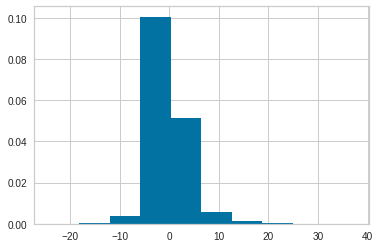

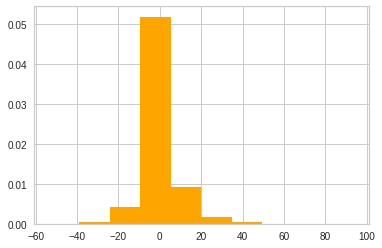

train rmsd =  3.323271079652017
test rmsd =  8.935845830554104
test r2 =  0.7877020299114119


In [25]:
# Validate the model on the train and test sets
from sklearn.metrics import r2_score
train_residuals = pipe2.predict(Xtrain) - ytrain
plt.hist(train_residuals,density=True)
plt.show()
test_residuals = pipe2.predict(Xtest) - ytest
plt.hist(test_residuals,color="orange",density=True)
plt.show()
print("train rmsd = ", train_residuals.describe()[2])
print("test rmsd = ", test_residuals.describe()[2])
print("test r2 = ", r2_score(ytest, pipe2.predict(Xtest)))